In [27]:
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch

from einops import rearrange
from importlib import import_module
from skp.toolbox.classes import Ensemble
from skp.toolbox.functions import draw_bounding_boxes, load_kfold_ensemble_as_list
from tqdm import tqdm

In [33]:
SAVE_CROPPED_IMAGES_DIR = "/mnt/stor/datasets/bone-age/cropped_train_plus_valid/"
os.makedirs(SAVE_CROPPED_IMAGES_DIR, exist_ok=True)

In [28]:
df = pd.read_csv("/mnt/stor/datasets/bone-age/train_plus_valid_kfold.csv")
df.head()

,pid,bone_age,female,subset,outer,inner0,inner1,inner2,inner3,inner4,fold,imgfile
0,1377,180,1,train,0,-1,3,3,3,3,0,train/1377.png
1,1378,12,1,train,3,2,4,4,-1,4,3,train/1378.png
2,1379,94,1,train,2,4,3,-1,4,3,2,train/1379.png
3,1380,120,0,train,1,3,-1,3,3,2,1,train/1380.png
4,1381,82,1,train,0,-1,2,2,2,1,0,train/1381.png


In [29]:
cfg_name = "boneage.cfg_crop_simple_resize"
cfg = import_module(f"skp.configs.{cfg_name}").cfg
weights_paths = [cfg.save_dir + cfg_name + f"/8b59fed7/fold{fold}/checkpoints/last.ckpt" for fold in [0, 1]]
model = load_kfold_ensemble_as_list(cfg, weights_paths=weights_paths)
model = Ensemble(model)
model = model.eval().cuda()

In [38]:
for row_idx, row in tqdm(df.iterrows(), total=len(df)):
    img0 = cv2.imread(os.path.join("/mnt/stor/datasets/bone-age", row.imgfile), cfg.cv2_load_flag)
    if img0.ndim == 2:
        img = rearrange(img0, "h w -> h w 1")
    img = cfg.val_transforms(image=img)["image"]
    img = torch.from_numpy(img).float()
    img = rearrange(img, "h w c -> 1 c h w")
    with torch.inference_mode():
        out = model(x=img.cuda())
    box = out.cpu().numpy()[0]
    box[[0, 2]] = box[[0, 2]] * img0.shape[1]
    box[[1, 3]] = box[[1, 3]] * img0.shape[0]
    box = box.astype("int")
    x, y, w, h = box
    cropped_img0 = img0[y:y+h, x:x+w]
    save_path = os.path.join(SAVE_CROPPED_IMAGES_DIR, f"{row.pid}.png")
    _ = cv2.imwrite(save_path, cropped_img0)

100%|██████████| 14036/14036 [05:23<00:00, 43.33it/s]


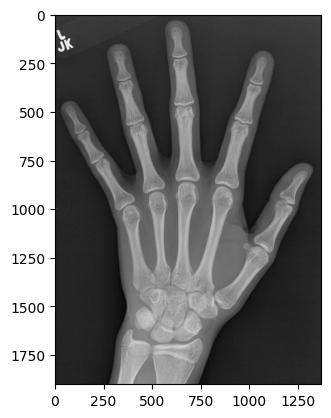

In [37]:
img = cv2.imread(save_path, 0)
plt.imshow(img, cmap="gray")

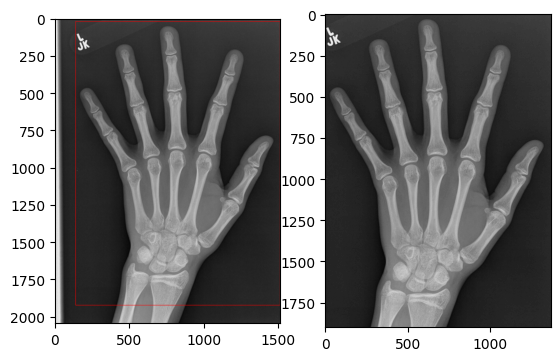

In [32]:
img_with_box = draw_bounding_boxes(img0, [box], mode="xywh")
plt.subplot(1, 2, 1)
plt.imshow(img_with_box, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(cropped_img0, cmap="gray")
plt.show()